In [2]:
import json
import pandas as pd

input_file = "/content/drive/MyDrive/mava/trendyol_limited.json"

with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(len(df))


334383


In [3]:
import re

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.strip()
        text = re.sub(r"\s+", " ", text)
        text = re.sub(r"[^\w\s]", "", text)
    return text

def preprocess_column(df, column_name):

    df[column_name] = df[column_name].apply(preprocess_text)
    return df

df = preprocess_column(df, "title")

df["title"].sample(10)

,title
202870,kadın kemerli crep kumaş tulum
77748,mavi karaoke bluetooth mikrofon ws858 usb ses ...
272693,dört torch siyah puro çakmağı ccm0551
254322,inci küpeli kız 1000 parça museum puzzle
185060,çelik cezve süt kahve cezvesi 50 cl
169507,kitaplık ahşap 5 raflı dekoratif kitaplık
318589,çilek aromalı maden suyu 24lü 200ml
250885,kırmızı oyuncak bebek yatağı seti
24446,kucuk taraklı puzzle hayal gucu
280477,20 x 400 9010016 fatbike dış lastik iç lastik ...


In [4]:
from sklearn.preprocessing import LabelEncoder

def mergeCategories(df, columns):
    df["merged_categories"] = df[columns].apply(lambda x: "_".join(x.astype(str)), axis=1)
    return df

df = mergeCategories(df, ["ana_kategori", "alt_kategori_1", "alt_kategori_2"])

le = LabelEncoder()
df['merged_categories_le'] = le.fit_transform(df['merged_categories'])

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def add_tokenized_column(df, text_column='title', token_column='tokenized_title', max_len=30, num_words=3000):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(df[text_column])

    sequences = tokenizer.texts_to_sequences(df[text_column])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    df[token_column] = list(padded_sequences)
    return df, tokenizer

df, tokenizer = add_tokenized_column(df, text_column='title')


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

padded = df["tokenized_title"]
X_train, X_test, y_train, y_test = train_test_split(
    padded, df["merged_categories_le"], test_size=0.2, random_state=42, stratify=df["merged_categories_le"]
)

X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
y_train = np.array(y_train.tolist())
y_test = np.array(y_test.tolist())

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Attention

def build_gru_model(input_length, vocab_size, num_classes, embedding_dim=128, gru_units=64, dropout_rate=0.5):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    gru_layer = GRU(gru_units, return_sequences=True)(embedding_layer)

    attention_layer = Attention()([gru_layer, gru_layer])

    global_pool = GlobalMaxPooling1D()(attention_layer)
    dropout_layer = Dropout(dropout_rate)(global_pool)
    dense_layer = Dense(64, activation="relu")(dropout_layer)
    output_layer = Dense(num_classes, activation="softmax")(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model


In [8]:
model = build_gru_model(input_length=30, vocab_size=3000, num_classes=len(df["merged_categories_le"].unique()))
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 128)   │    384,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 30, 64)    │     37,248 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 64)    │          0 │ gru[0][0],        │
│ (Attention)         │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 460)       │     29,900 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 455,308 (1.74 MB)

 Trainable params: 455,308 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 327s 39ms/step - accuracy: 0.0867 - loss: 4.9924 - val_accuracy: 0.5536 - val_loss: 2.1358
Epoch 2/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 379s 38ms/step - accuracy: 0.5186 - loss: 2.2466 - val_accuracy: 0.6322 - val_loss: 1.6767
Epoch 3/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 321s 38ms/step - accuracy: 0.5892 - loss: 1.8535 - val_accuracy: 0.6560 - val_loss: 1.5252
Epoch 4/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 328s 39ms/step - accuracy: 0.6217 - loss: 1.6796 - val_accuracy: 0.6716 - val_loss: 1.4424
Epoch 5/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 372s 38ms/step - accuracy: 0.6381 - loss: 1.5850 - val_accuracy: 0.6814 - val_loss: 1.3968
Epoch 6/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 319s 38ms/step - accuracy: 0.6508 - loss: 1.5174 - val_accuracy: 0.6905 - val_loss: 1.3509
Epoch 7/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 322s 38ms/step - accuracy: 0.6600 - loss: 1.4666 - val_accuracy: 0.6944 - val_loss: 1.3279
Epoch 8/30
8360/8360 ━━━━━━━━━━━━━━━━━━━━ 328s 39ms/step - accuracy: 

In [12]:
def predict_product(product_name, tokenizer, labelencoder):

    product_name = product_name.lower().strip()
    sequence = tokenizer.texts_to_sequences([product_name])
    padded_sequence = pad_sequences(sequence, maxlen=30, padding="post")
    pred_probs = model.predict(padded_sequence)
    pred_class = np.argmax(pred_probs, axis=1)

    predicted_category = labelencoder.inverse_transform(pred_class)

    return predicted_category[0]


test_products = ["sleepy bebek bezi çok rahat ve sızdırmaz", "bebek bezi sleepy", "ultra güçlü bebek bezi sızdırmayan sleepy"]
print("\nÖzel Ürün Adları İçin Tahminler:")
for product in test_products:
    predicted_label = predict_product(product, tokenizer, le)
    print(f"Ürün: '{product}'")
    print(f"Tahmin Edilen Etiket: {predicted_label}\n")


Özel Ürün Adları İçin Tahminler:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Ürün: 'sleepy bebek bezi çok rahat ve sızdırmaz'
Tahmin Edilen Etiket: Anne & Çocuk_Bebek Bakım_Bebek Bakım ve Kozmetik

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Ürün: 'bebek bezi sleepy'
Tahmin Edilen Etiket: Anne & Çocuk_Bebek_Müslin Bez

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Ürün: 'ultra güçlü bebek bezi sızdırmayan sleepy'
Tahmin Edilen Etiket: Anne & Çocuk_Bebek Bakım_Bebek Bakım ve Kozmetik



2090/2090 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


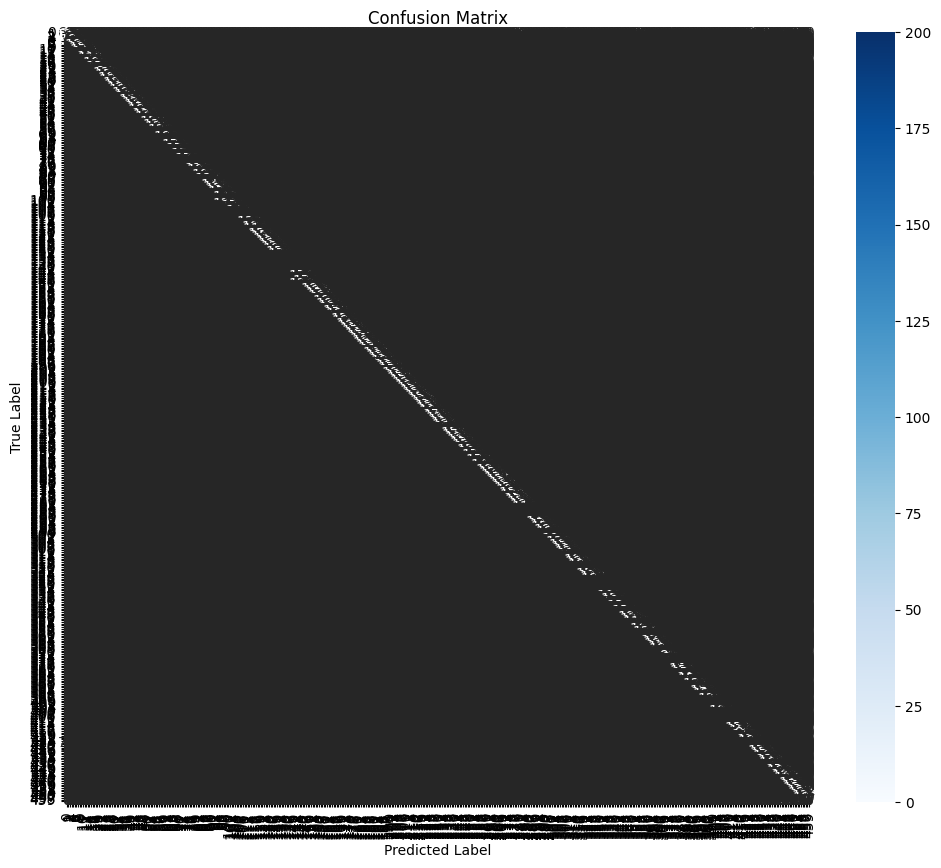


Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.60      0.51       101
           1       0.71      0.62      0.66       200
           2       0.96      0.81      0.88       200
           3       0.00      0.00      0.00        23
           4       0.88      0.94      0.91       200
           5       0.53      0.87      0.66        47
           6       0.38      0.69      0.49        54
           7       0.96      0.94      0.95       200
           8       0.99      0.95      0.97       200
           9       0.98      0.97      0.98       200
          10       0.87      0.92      0.90       191
          11       0.57      0.70      0.63       200
          12       0.75      0.65      0.70        89
          13       0.47      0.44      0.46       200
          14       0.75      0.55      0.63       200
          15       0.65      0.56      0.60       200
          16       0.38      0.28      0.32       200
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Tahminler
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = df["merged_categories_le"].unique()
labels_sorted = np.sort(labels)  # Etiket sırasını garanti altına alır

# 3. Matris görselleştirme
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4. Ek olarak detaylı metrikler
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(l) for l in labels_sorted]))


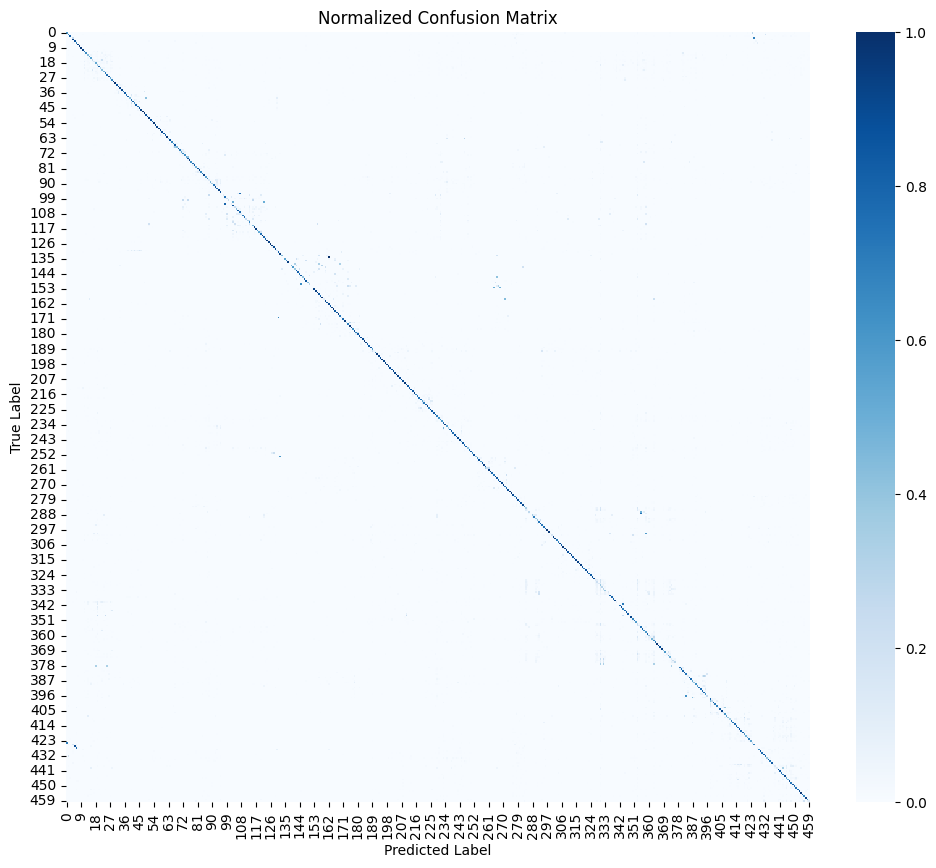

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred, normalize='true')  # normalize ekledik

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step


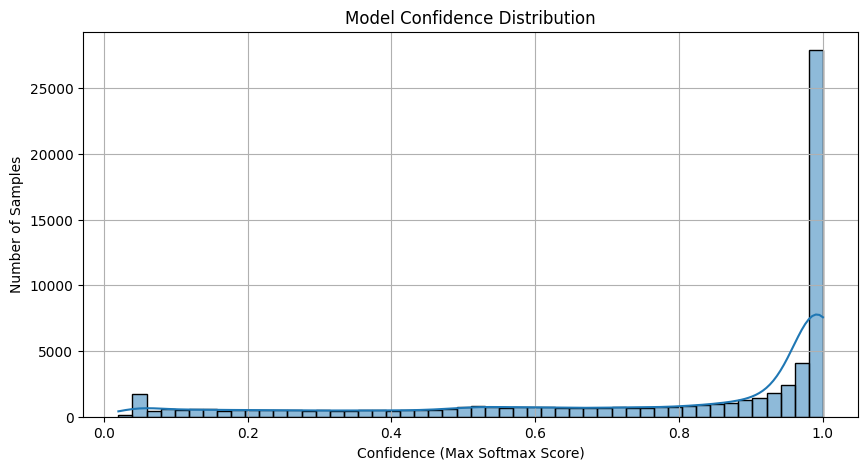

Avg confidence (correct): 0.89186
Avg confidence (incorrect): 0.44203696


In [15]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_proba = model.predict(X_test)
max_confidences = np.max(y_proba, axis=1)
plt.figure(figsize=(10, 5))
sns.histplot(max_confidences, bins=50, kde=True)
plt.title("Model Confidence Distribution")
plt.xlabel("Confidence (Max Softmax Score)")
plt.ylabel("Number of Samples")
plt.grid()
plt.show()

correct_mask = y_pred == y_test
incorrect_mask = ~correct_mask
print("Avg confidence (correct):", np.mean(max_confidences[correct_mask]))
print("Avg confidence (incorrect):", np.mean(max_confidences[incorrect_mask]))


In [16]:
model.save("/content/drive/MyDrive/mava/model2.h5")

In [17]:
import pickle

with open('/content/drive/MyDrive/mava/tokenizer2.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [18]:
with open('/content/drive/MyDrive/mava/label_encoder2.pkl', 'wb') as f:
    pickle.dump(le, f)
